In [1]:
# Import libraries
import pandas as pd
from pathlib import Path
from pyspark.sql import SparkSession
#import hvplot.pandas

In [2]:
### DATA LOADING ###

spark = SparkSession.builder.appName("CreditCardFraudDetection").getOrCreate()
file_path = "creditcard.csv"  
data = spark.read.csv(file_path, header=True, inferSchema=True)
dataset_path = "creditcard.csv"
data = pd.read_csv(dataset_path)

In [3]:
### DATA EXPLORATION ###

print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
# Print 
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# Describe cols
print(data.describe())


                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [6]:
# Check if anything is missing
print(data.isnull().sum())


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [7]:
# Define class
class_distribution = data['Class'].value_counts()
print(class_distribution)


Class
0    284315
1       492
Name: count, dtype: int64


In [8]:
### DATA PREPROCESSING ###

missing_values = data.isnull().sum().sum()

if missing_values == 0:
    print("There are no missing values in the dataset.")
else:
    print(f"There are {missing_values} missing values in the dataset.")


There are no missing values in the dataset.


In [9]:
# IQR

# for Amount col
Q1 = data['Amount'].quantile(0.25)
Q3 = data['Amount'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = data[(data['Amount'] < lower_bound) | (data['Amount'] > upper_bound)]
data = data[~data.index.isin(outliers.index)]


In [10]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))

Class
0    252502
1       401
Name: count, dtype: int64


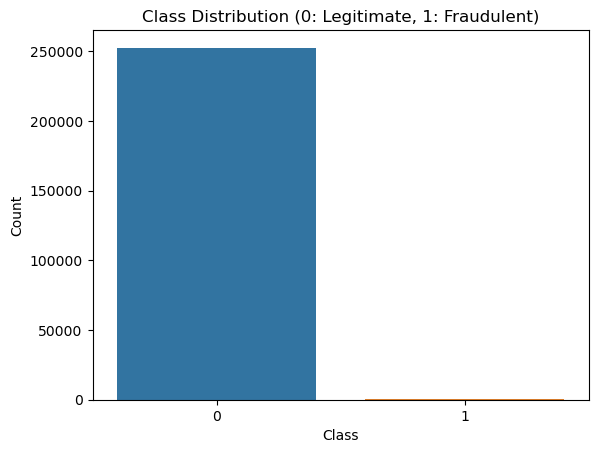

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns


class_distribution = data['Class'].value_counts()
print(class_distribution)

sns.countplot(x='Class', data=data)
plt.title('Class Distribution (0: Legitimate, 1: Fraudulent)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [12]:
# Check imbalance
from imblearn.over_sampling import RandomOverSampler

X = data.drop('Class', axis=1)
y = data['Class']

oversampler = RandomOverSampler(sampling_strategy='minority')
X_resampled_over, y_resampled_over = oversampler.fit_resample(X, y)


In [13]:
from imblearn.under_sampling import RandomUnderSampler

# Separate features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Random undersampling
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_resampled_under, y_resampled_under = undersampler.fit_resample(X, y)

In [14]:
# Pre-process data
from sklearn.model_selection import train_test_split
X = data.drop('Class', axis=1)  
y = data['Class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (177032, 30)
X_test shape: (75871, 30)
y_train shape: (177032,)
y_test shape: (75871,)


In [15]:
# ML model

from sklearn.ensemble import RandomForestClassifier


rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)


In [16]:
from sklearn.metrics import classification_report, roc_auc_score

# Evaluate Random Forest model
print("Random Forest Model:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

Random Forest Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75742
           1       0.92      0.76      0.83       129

    accuracy                           1.00     75871
   macro avg       0.96      0.88      0.92     75871
weighted avg       1.00      1.00      1.00     75871

ROC-AUC: 0.8797921503823978


In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Adjust the number of trees
    max_depth=10,      # Adjust the maximum depth of trees
    random_state=42
)

rf_classifier.fit(X_train, y_train)



RandomForestClassifier(max_depth=10, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75742
           1       0.92      0.75      0.83       129

    accuracy                           1.00     75871
   macro avg       0.96      0.88      0.91     75871
weighted avg       1.00      1.00      1.00     75871

ROC AUC Score: 0.8759161813901496


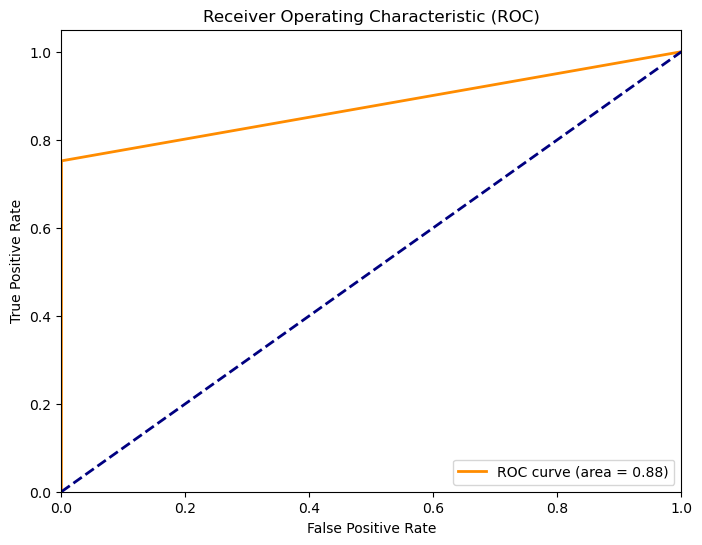

In [18]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


y_pred = rf_classifier.predict(X_test) 

classification_report_result = classification_report(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

print("Classification Report:")
print(classification_report_result)
print("ROC AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
spark.stop()